In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install adversarial-robustness-toolbox

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 59.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()
from keras.models import Model
# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam, SGD
from matplotlib import pyplot as plt
from art.attacks.evasion import BoundaryAttack
from art.estimators.classification import KerasClassifier
from art.utils import to_categorical
from art.attacks.evasion import ProjectedGradientDescent
import imageio
from tensorflow.keras.applications import vgg16

import sys
from pathlib import Path
import datetime
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam, SGD
from matplotlib import pyplot as plt
from art.attacks.evasion import BoundaryAttack
from art.estimators.classification import KerasClassifier
from art.utils import to_categorical
from art.attacks.evasion import ProjectedGradientDescent
import imageio
from tensorflow.keras.applications import vgg16

TensorFlow version:2.12.0
Keras version:2.12.0


In [3]:
# Uncompress the dataset 
!unzip -uq "/content/drive/MyDrive/ass1/Dataset_dog_breeds.zip" -d "sample_data/"

In [4]:
# Function to load the images 
def load_images(directory):

    imgs_list = []

    # List of all images in the directory
    imgs_list_1 = listdir(directory)
    # Make sure that the images are sorted 
    imagesList = natsort.natsorted(imgs_list_1)

    # Read the images as numpy arrays
    for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
          img_arr = np.array(tmp_img)
          imgs_list.append(img_arr/255.)
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

# Load the images
all_images = load_images('sample_data/Dataset_dog_breeds')
print('Shape of the images:', all_images.shape)

Shape of the images: (1961, 256, 256, 3)


In [5]:
# Load the labels
all_labels = np.loadtxt('/content/drive/MyDrive/ass1/labels_dog_breeds.csv', delimiter=',').astype(int)
print('Shape of the labels:', all_labels.shape)

Shape of the labels: (1961,)


In [6]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images

In [7]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (1254, 256, 256, 3) - Labels train shape: (1254,)
Images validation shape: (314, 256, 256, 3) - Labels validation shape: (314,)
Images test shape: (393, 256, 256, 3) - Labels test shape: (393,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.44233429646671163
Data type float64


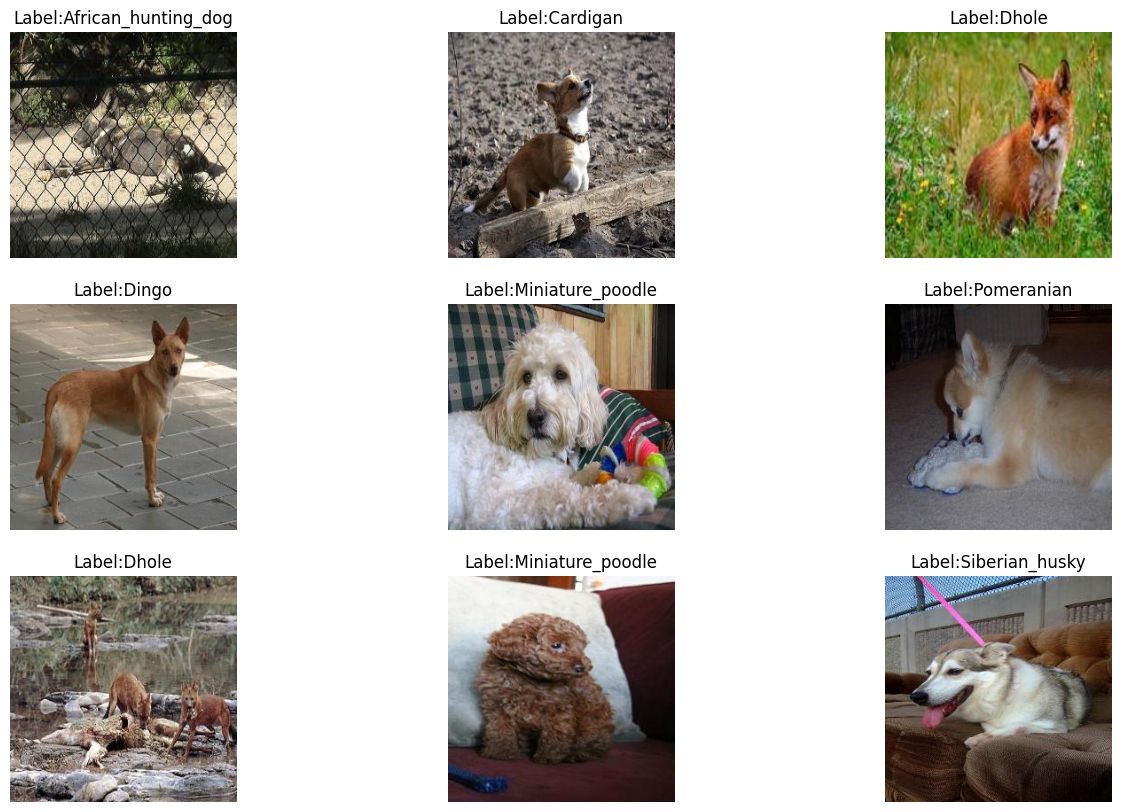

In [8]:
# A list with the names of the image classes
label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', 
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']

# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [9]:
NUM_CLASSES = 12
from tensorflow.keras.utils import to_categorical


train_labels_onehot = to_categorical(train_labels, NUM_CLASSES)
val_labels_onehot = to_categorical(val_labels, NUM_CLASSES)
test_labels_onehot = to_categorical(test_labels, NUM_CLASSES)

In [10]:
BATCH_SIZE = 64                             # Size of batch
HEIGHT = 256                                 # Height of input image
WIDTH = 256                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 3                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 30                         # Number of epoch to train
LR = 1e-4

In [11]:

base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_tensor=keras.layers.Input((256,256,3)))#ResNet50
# Fine-tune ResNet50 mdodel.
# Add several Dense layers on top of it and a softmax dense layer with output dense of 3 labels
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu')(x)
predictions = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=[base_model.input], outputs=[predictions])

Instructions for updating:
Colocations handled automatically by placer.


17225924/17225924 [==============================] - 1s 0us/step


In [12]:

optimizer = keras.optimizers.Adam(learning_rate=LR)

callbacks = [EarlyStopping(monitor='val_loss',
                   patience = 5,
                   restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
            
            ]
     

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])


history = model.fit(train_images, train_labels_onehot, epochs = NUM_EPOCH, batch_size = BATCH_SIZE, validation_data = (val_images, val_labels_onehot),callbacks=callbacks)

Train on 1254 samples, validate on 314 samples
Epoch 1/30
1254/1254 [==============================] - ETA: 0s - loss: 2.4039 - accuracy: 0.1754

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1254/1254 [==============================] - 18s 14ms/sample - loss: 2.4039 - accuracy: 0.1754 - val_loss: 2.1966 - val_accuracy: 0.3121 - lr: 1.0000e-04
Epoch 2/30
1254/1254 [==============================] - 4s 4ms/sample - loss: 1.9492 - accuracy: 0.3995 - val_loss: 1.6487 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/30
1254/1254 [==============================] - 5s 4ms/sample - loss: 1.3536 - accuracy: 0.5957 - val_loss: 1.0305 - val_accuracy: 0.7038 - lr: 1.0000e-04
Epoch 4/30
1254/1254 [==============================] - 4s 4ms/sample - loss: 0.8033 - accuracy: 0.7568 - val_loss: 0.7016 - val_accuracy: 0.7962 - lr: 1.0000e-04
Epoch 5/30
1254/1254 [==============================] - 5s 4ms/sample - loss: 0.4900 - accuracy: 0.8397 - val_loss: 0.5461 - val_accuracy: 0.7803 - lr: 1.0000e-04
Epoch 6/30
1254/1254 [==============================] - 4s 4ms/sample - loss: 0.4053 - accuracy: 0.8453 - val_loss: 0.4853 - val_accuracy: 0.8185 - lr: 1.0000e-04
Epoch 7/30
1254/1254 [=========

In [13]:
trainval_labels_onehot = to_categorical(trainval_labels, NUM_CLASSES)
results = model.evaluate(test_images, test_labels_onehot)
print("test loss, test acc:", results)
results = model.evaluate(trainval_images, trainval_labels_onehot)
print("trainval test loss, trainval test acc:", results)

test loss, test acc: [0.4230026554970341, 0.83206105]
trainval test loss, trainval test acc: [0.10735828566307924, 0.96811223]


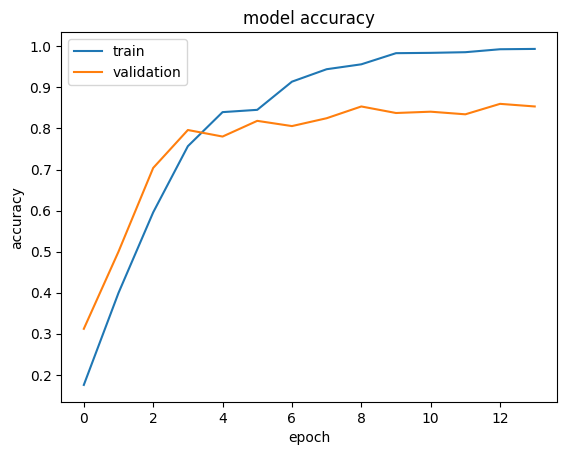

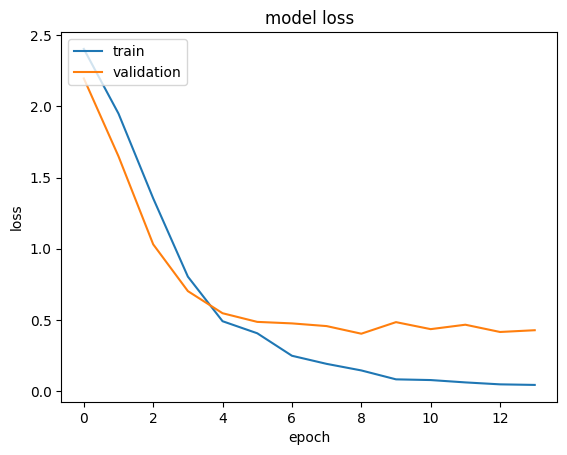

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
PROJECT_ROOT_DIR = '/content/drive/MyDrive/ass1/'
model_save_path = PROJECT_ROOT_DIR + 'xxx.h5'
model.save(model_save_path)


In [16]:
path = "/content/drive/MyDrive/ass1/"
loaded_model = load_model(path + "xxx.h5")

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


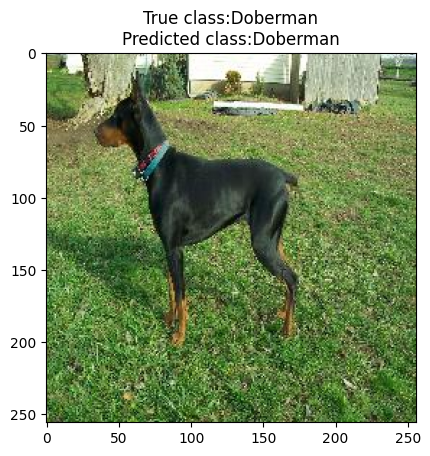

In [17]:
base_image_index = 2
sample_dog_image = test_images[base_image_index]
plt.imshow(sample_dog_image)
label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', \
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']

true_class = label_names[test_labels[base_image_index]]
predicted_class = label_names[np.argmax(loaded_model.predict(test_images[base_image_index:base_image_index + 1]))]
plt.title('True class:' + true_class+ '\n' + 'Predicted class:' + predicted_class)
plt.show()

In [18]:
adv_img = test_images[base_image_index]
sample_dog_fig_path = path + "untargeted/untargeted_origin.png"
imageio.imwrite(sample_dog_fig_path, adv_img)


In [19]:
class PGD_Attack:
    def __init__(self, IMAGE_DATASET = None, IMAGE_LABELS = None, TARGET_IMAGE_INDEX = None):
        self.image_dataset = IMAGE_DATASET.copy()
        self.image_labels = IMAGE_LABELS.copy()
        self.target_image_index = TARGET_IMAGE_INDEX

        self.base_image_index = 2
        self.loaded_model = self.load_the_model()
        self.epsilon_list = [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

        self.label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', \
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']
            

    def load_init_img(self):
        return self.image_dataset[self.base_image_index][np.newaxis, :, :, :]/255.

    def load_init_label(self):
        return self.image_labels[self.base_image_index][np.newaxis, :]

    def pgd_attack(self, Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
        
        attackPgd = ProjectedGradientDescent(estimator = Classifier,
                                            eps=(Epsilon/255),
                                            targeted=Targeted,
                                            batch_size =256)
  
        if Targeted == True and Labels is not None:
            return attackPgd.generate(Imgs_Test,Labels)
        
 
        elif Targeted == False:
            return attackPgd.generate(Imgs_Test)
    
        else:
            print("make sure you have given the function: pgd_attack a set of labels if you are doing targeted attacks")
            print("Stopping program ...")
           
    def load_the_model(self):
        MODEL_DIR = "p1"
        model_name = "p2_trans_res.h5"
        working_path = os.path.join(path, MODEL_DIR, model_name)

        loaded_model = load_model(working_path)
        return loaded_model

    def train_model(self):
 
        self.init_img = self.load_init_img()
        self.labels_adv_cat = self.load_init_label()
        

        pgd_acc_list = []
        pgd_image_list = []
        pgd_pred_list = []
        pgd_pertb_list = []
        pgd_image_whole_list = []

        epsilon_list = self.epsilon_list

        classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 255))

        for eps in epsilon_list:
            if None == self.target_image_index:
                imgs_adv_pgd = self.pgd_attack(eps*255,classifier,self.init_img,Targeted=False,Labels=self.labels_adv_cat)
            else:
                targeted_label = keras.utils.to_categorical(self.target_image_index, 12)[np.newaxis, :]

                imgs_adv_pgd = self.pgd_attack(eps*255,classifier,self.init_img,Targeted=True,Labels=targeted_label)
            
            pgd_image_whole_list.append(imgs_adv_pgd)
    
            prediction_pgd = self.loaded_model.predict(imgs_adv_pgd[0:1,:,:,:]*255)
            
            pgd_pred_list.append(prediction_pgd.argmax(axis=-1))

        self.save_npy(pgd_image_whole_list, "pgd_image_whole_list")
        self.save_npy(pgd_pred_list, "pgd_pred_list")

    def get_np_path(self):
        if None == self.target_image_index:
            np_data_path = "/content/drive/MyDrive/ass1/untargeted/"
        else:
            np_data_path = "/content/drive/MyDrive/ass1/targeted/"
        Path(np_data_path).mkdir(parents=True, exist_ok=True)
        return np_data_path

    def save_npy(self, NPY, FILENAME):
        NPY = np.asarray(NPY)
        np_data_path = self.get_np_path()
        np.save(np_data_path + FILENAME, NPY)

    def load_saved_npy(self):
        np_data_path = self.get_np_path()
        self.pgd_image_whole_list = np.load(np_data_path + "pgd_image_whole_list.npy")
        self.pgd_pred_list = np.load(np_data_path + "pgd_pred_list.npy")




In [20]:
all_images = np.load(path + "p1all_images.npy")
all_labels = np.load(path + "p1all_labels.npy")

trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images

train_labels_onehot = keras.utils.to_categorical(train_labels, 12)
test_labels_onehot = keras.utils.to_categorical(test_labels, 12)
val_labels_onehot = keras.utils.to_categorical(val_labels, 12)

label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', \
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']
     

In [21]:
pa1 = PGD_Attack(test_images, test_labels_onehot)
pa1.train_model()


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
pa1v = PGD_Attack(test_images, test_labels_onehot)
pa1v.load_saved_npy()


In [23]:
label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', \
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']
     

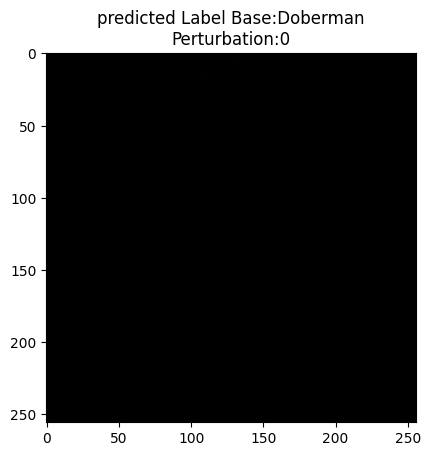

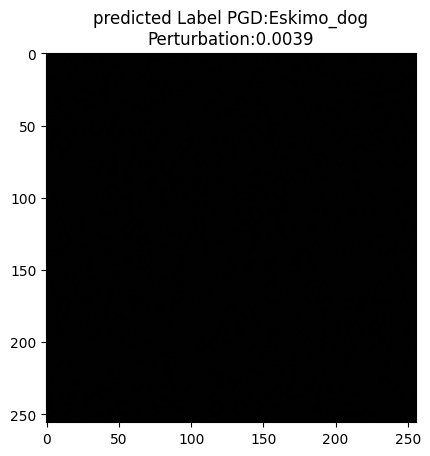

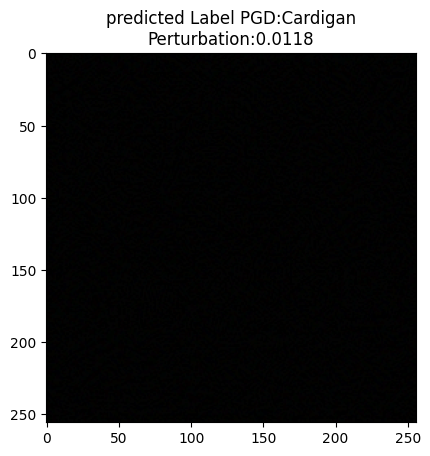

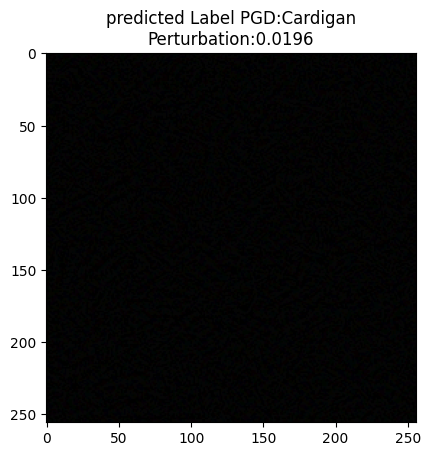

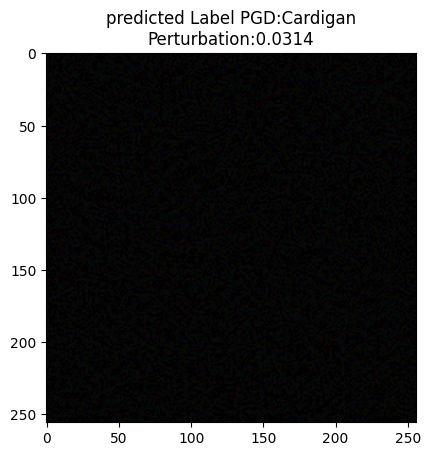

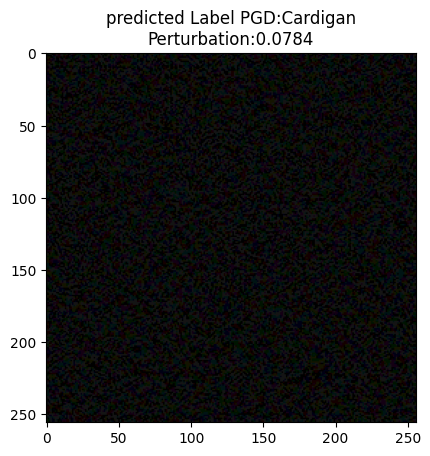

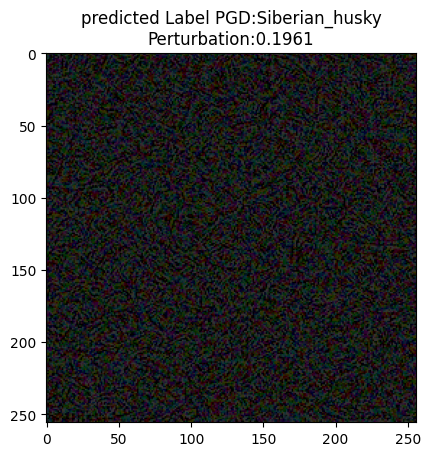

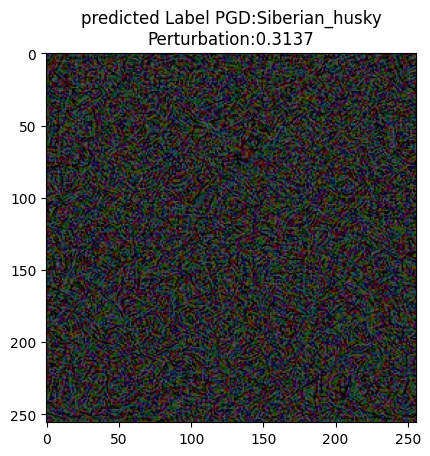

In [24]:
def show_images(EpsilonIndex, PA):

    plt.title('predicted Label PGD:' + str(label_names[int(PA.pgd_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(PA.epsilon_list[EpsilonIndex],4)))
    plt.imshow(PA.pgd_image_whole_list[EpsilonIndex][0])
    
    adv_img = PA.pgd_image_whole_list[EpsilonIndex][0]
    untarget_dog_fig_path = path + "untargeted/untargeted_eps" + str(EpsilonIndex) +".png"
    imageio.imwrite(untarget_dog_fig_path, adv_img)
    plt.show()

def show_all_images(PA):
    plt.title('predicted Label Base:' + str(label_names[np.argmax(PA.load_init_label()[0])])+ '\n' + 'Perturbation:' + str(0))
    plt.imshow(PA.load_init_img()[0])
    plt.show()
   
    for index, item in enumerate(PA.epsilon_list):
        show_images(index, PA)

show_all_images(pa1v)

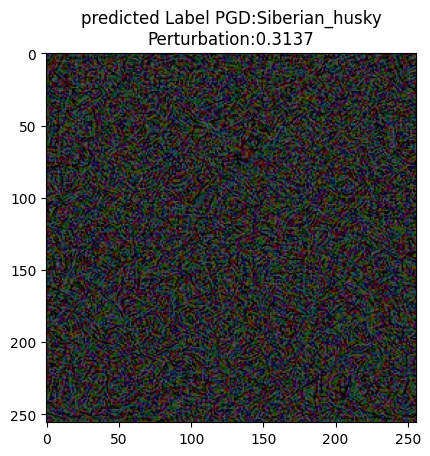

In [25]:
eps_index = 6
plt.title('predicted Label PGD:' + str(label_names[int(pa1v.pgd_pred_list[eps_index])])+\
          '\n' + 'Perturbation:' + str(round(pa1v.epsilon_list[eps_index],4)))
plt.imshow(pa1v.pgd_image_whole_list[eps_index][0])


In [26]:
all_images = np.load(path + "p1all_images.npy")
all_labels = np.load(path + "p1all_labels.npy")

trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images

train_labels_onehot = keras.utils.to_categorical(train_labels, 12)
test_labels_onehot = keras.utils.to_categorical(test_labels, 12)
val_labels_onehot = keras.utils.to_categorical(val_labels, 12)

In [27]:
targeted_index = 6
print("Target dog: ", label_names[targeted_index])
pa1 = PGD_Attack(test_images, test_labels_onehot,targeted_index)
pa1.train_model()

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', \
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']
     
print("Target dog: ", label_names[targeted_index])
pa2v = PGD_Attack(test_images, test_labels_onehot, targeted_index)
pa2v.load_saved_npy()

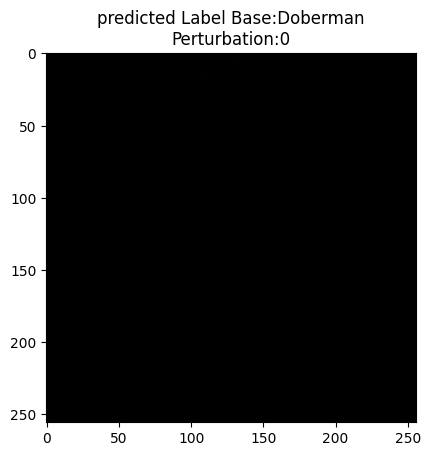

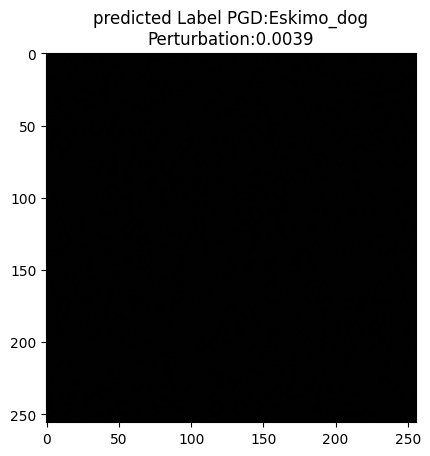

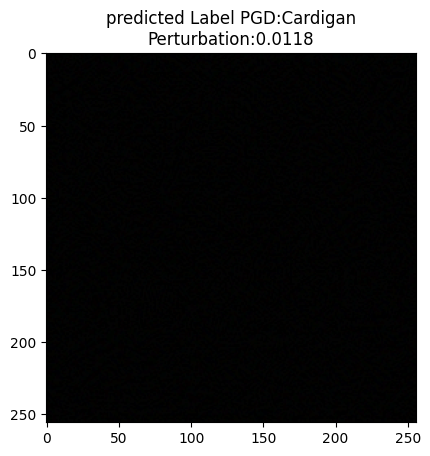

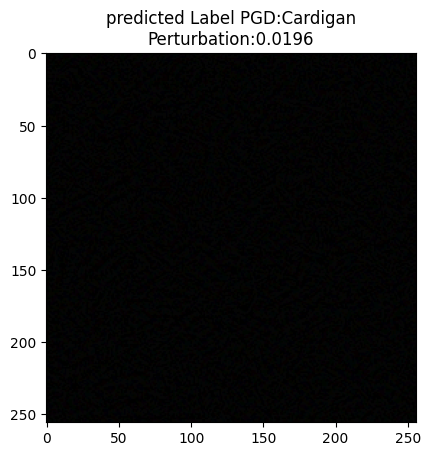

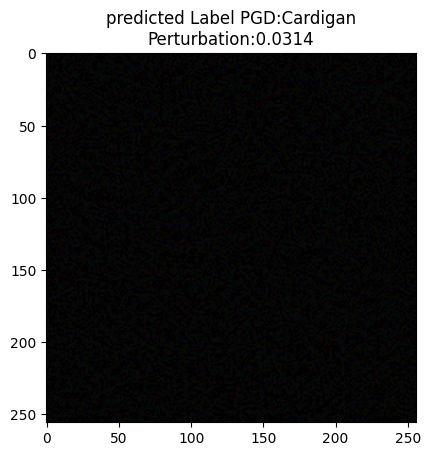

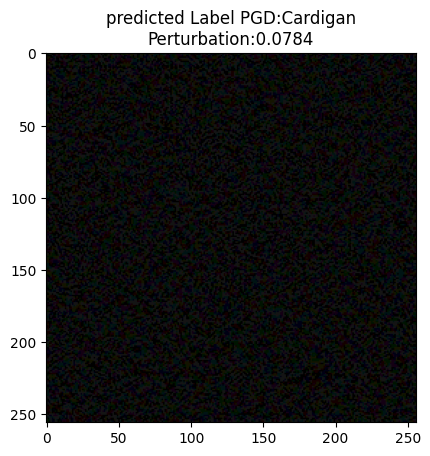

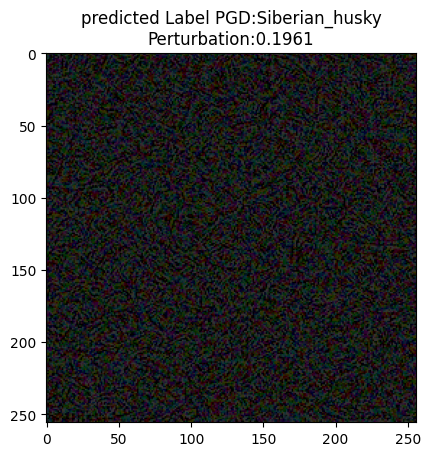

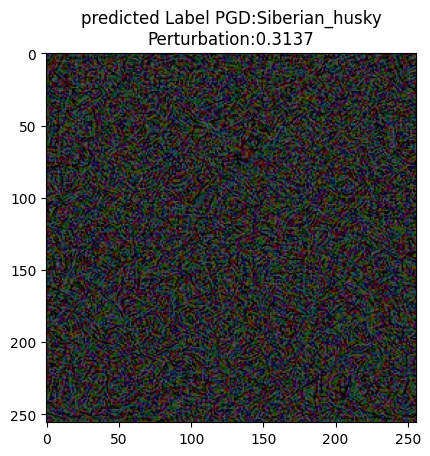

In [30]:
def show_images(EpsilonIndex, PA):
    
    plt.title('predicted Label PGD:' + str(label_names[int(PA.pgd_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(PA.epsilon_list[EpsilonIndex],4)))
    plt.imshow(PA.pgd_image_whole_list[EpsilonIndex][0])

    adv_img = PA.pgd_image_whole_list[EpsilonIndex][0]
    untarget_dog_fig_path = path + "untargeted/untargeted_eps" + str(EpsilonIndex) +".png"
    imageio.imwrite(untarget_dog_fig_path, adv_img)
    plt.show()

def show_all_images(PA):
    plt.title('predicted Label Base:' + str(label_names[np.argmax(PA.load_init_label()[0])])+ '\n' + 'Perturbation:' + str(0))
    plt.imshow(PA.load_init_img()[0])
    plt.show()

    for index, item in enumerate(PA.epsilon_list):
        show_images(index, PA)


show_all_images(pa1v)
     

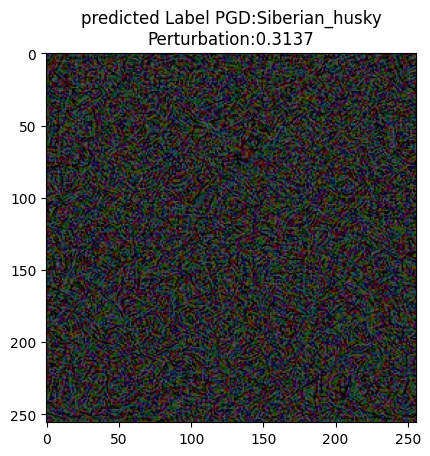

In [31]:
eps_index = 6
plt.title('predicted Label PGD:' + str(label_names[int(pa1v.pgd_pred_list[eps_index])])+\
          '\n' + 'Perturbation:' + str(round(pa1v.epsilon_list[eps_index],4)))
plt.imshow(pa1v.pgd_image_whole_list[eps_index][0])
